## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Import lines

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


## Extracting "object points" and "image points" for camera calibration using chessboard images.

In [2]:

def create_points_for_calibration():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    img_size = None
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        img_size = (img.shape[1], img.shape[0])
        
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            plt.imshow(img)

    cv2.destroyAllWindows()
    
    return objpoints, imgpoints, img_size

---
## Compute the camera calibration matrix and distortion using objpoints and imgpoints
Using `objpoints` and `imgpoints` which areneeded for camera calibration, the cell below calibrates and calculates distortion coefficients. We test undistortion on an image!

In [3]:
def calibrate_camera():
    objpoints, imgpoints, img_size = create_points_for_calibration()
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return mtx, dist


### Save and Load

In [4]:
# Save and Load the camera calibration results for later use (we won't worry about rvecs / tvecs)
calibration_file = "camera_cal_pickle.p"

if os.path.exists(calibration_file):
    dist_pickle = pickle.load(open(calibration_file,"rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    print("Camera calibration Matrix loaded!")
    
else:
    mtx, dist = calibrate_camera()
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( calibration_file, "wb" ) )
    print("Camera calibration Matrix created successfully!")

Camera calibration Matrix loaded!


### Test undistortion on a chessboard image


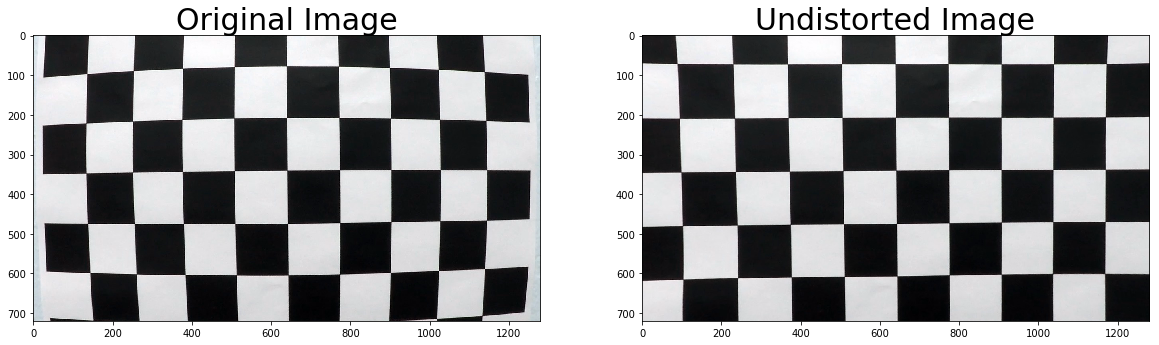

In [5]:
img = cv2.imread('camera_cal/calibration1.jpg')

#undistort image
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Apply a distortion correction to raw images.

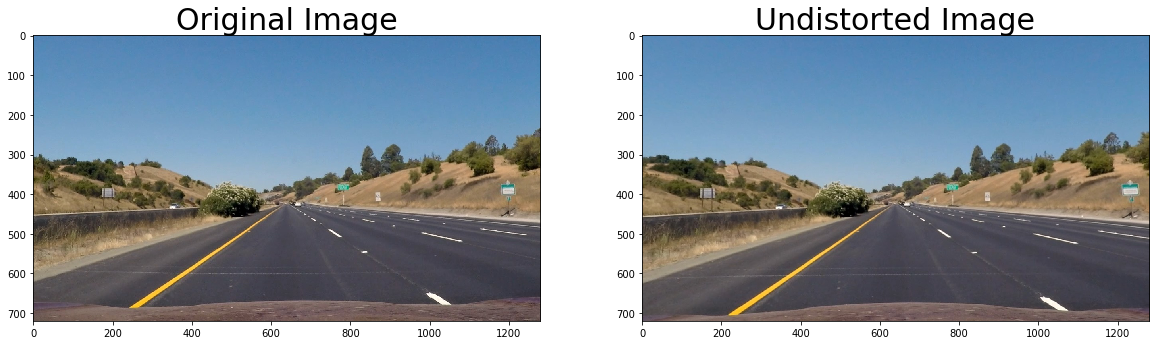

In [6]:
# Visualize undistortion for a road image.

img = cv2.imread('test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])

undist_img = cv2.undistort(img, mtx, dist, None, mtx)

#save the output
cv2.imwrite('output_images/straight_lines1_undist.jpg',undist_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist_img = cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=30)

## Apply a perspective transform to rectify road images ("birds-eye view").

---
### warper function


In [7]:
#warper function
def warper(img, M):

    # Apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped


### Calculate transform matrices

In [8]:
def compute_transform(img_size):
    #defining 4 source points src = np.float32([[,],[,],[,],[,]])
    #Note: you could pick any four of the detected corners 
    # as long as those four corners define a rectangle
    
    src = np.float32([[180,720],[560,470],[725,470],[1125,720]]) 
#     #New transform values for resubmit

#     src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],\
#                  [((img_size[0] / 6) - 10), img_size[1]],\
#                   [(img_size[0] * 5 / 6) + 60, img_size[1]],\
#                   [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])

#     #defining 4 destination points dst = np.float32([[,],[,],[,],[,]])

    dest = np.float32([[250,720],[250,0],[950,0],[950,720]])
#     #New transform values for resubmit
#     dest = np.float32([[(img_size[0] / 4), 0],\
#                   [(img_size[0] / 4), img_size[1]],\
#                   [(img_size[0] * 3 / 4), img_size[1]],\
#                   [(img_size[0] * 3 / 4), 0]])
    
    #use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dest)
    #Compute the inverse perspective transform to map future detected lane lines
    Minv = cv2.getPerspectiveTransform(dest, src)
    
    return M, Minv

### Load and Save

In [9]:
# Compute, Save, and Load the transform and inverse perspective transform to map future detected lane lines
transform_file = "transform_pickle.p"

if os.path.exists(transform_file):
    trans_pickle = pickle.load(open(transform_file,"rb"))
    M = trans_pickle['M']
    Minv = trans_pickle['Minv']
    print("Transform Matrix loaded!")
    
else:
    M, Minv = compute_transform(img_size)
    trans_pickle = {}
    trans_pickle['M'] = M
    trans_pickle['Minv'] = Minv
    pickle.dump( trans_pickle, open( transform_file, "wb" ) )
    print("Transform Matrix created successfully!")

Transform Matrix loaded!


### test the transform matrix

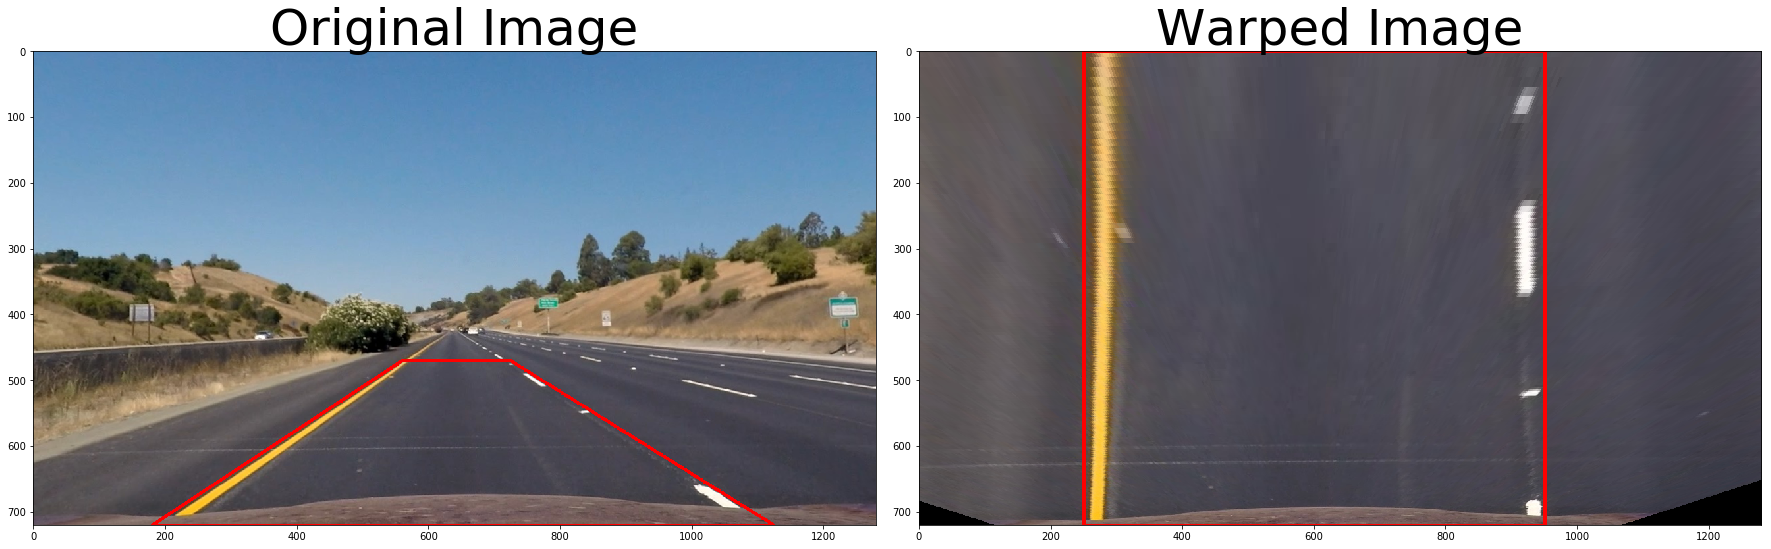

In [30]:
# warp the image to a top-down view
img_warped = warper(undist_img, M)
#save the output
# cv2.polylines(undist_img,np.int_(np.array([src])),True,(255,0,0),3)
# cv2.polylines(img_warped,np.int_(np.array([dest])),True,(255,0,0),3)

tmp = cv2.cvtColor(img_warped, cv2.COLOR_RGB2BGR)


cv2.imwrite('output_images/warped_straight_lines1.jpg',tmp)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_warped)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Check Warper on a curvy road image!

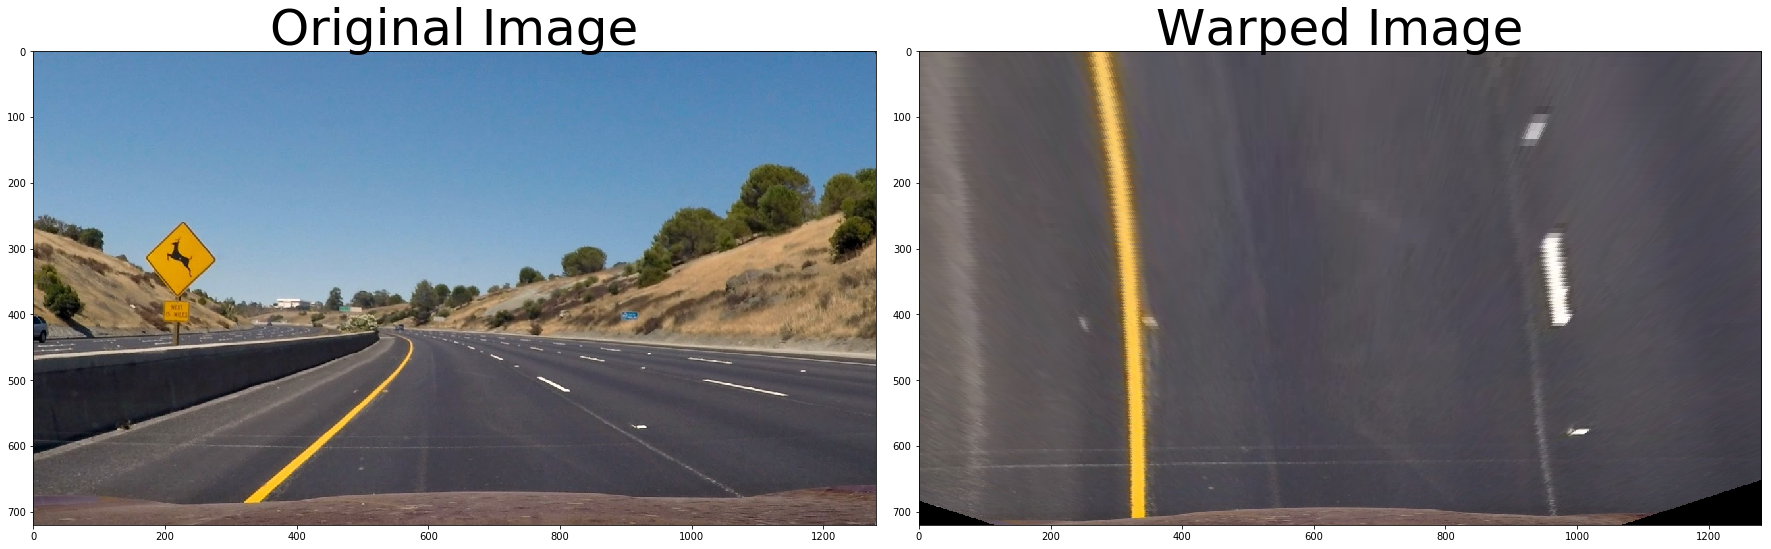

In [11]:
test_img = cv2.imread('test_images/test2.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_undist = cv2.undistort(test_img, mtx, dist, None, mtx)

test_top_down = warper(test_undist, M)

tmp = cv2.cvtColor(test_top_down, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/warped_curvy_test2.jpg',tmp)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_top_down,cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Using color transforms, gradients, etc., to create a thresholded binary image.

---
### Sobel Gradient functions

In [12]:
# Sobel Gradient
def abs_sobel_thresh(single_channel_img, orient='x', sobel_kernel = 3, abs_thresh = (0,255)):#(20,100)
    
    gray = np.float32(single_channel_img)
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)) # Take the derivative in x
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)) # Take the derivative in y
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Threshold the gradient
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1
    
    return sbinary

#Magnitude of Gradient
def mag_sobel_thresh(single_channel_img, sobel_kernel = 3, mag_thresh = (0,255)):#(30,100)
    
    gray = np.float32(single_channel_img)
    
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)) # Take the derivative in x
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)) # Take the derivative in y
    
    sobelxy = np.sqrt(np.power(sobelx,2)+np.power(sobely,2))
    
    scaled_sobel = np.uint8(255*sobelxy/np.max(sobelxy))
    
    # Threshold the gradient
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return sbinary

#Direction of Gradient
def dir_sobel_thresh(single_channel_img, sobel_kernel = 3, dir_thresh = (0,np.pi/2)):#(0.7,1.3)
    
    gray = np.float32(single_channel_img)
    
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)) # Take the derivative in x
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)) # Take the derivative in y
    
    arctan_sobelxy = np.arctan2(sobely,sobelx)
        
    # Threshold the gradient
    sbinary = np.zeros_like(arctan_sobelxy)
    sbinary[(arctan_sobelxy >= dir_thresh[0]) & (arctan_sobelxy <= dir_thresh[1])] = 1

    return sbinary

### Color space conversion and thresholding

In [13]:
def color_space_thresh(img):
    
    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # For yellow
    yellow = cv2.inRange(HSV, (20, 100, 100), (50, 255, 255))
    
    # For white
    sensitivity_1 = 68 
    white = cv2.inRange(HSV, (0,0,255-sensitivity_1), (255,20,255))
    
    sensitivity_2 = 60
    HSL = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    white_2 = cv2.inRange(HSL, (0,255-sensitivity_2,0), (255,255,sensitivity_2))
    
    white_3 = cv2.inRange(img, (200,200,200), (255,255,255))
    # Threshold color channel
    bit_layer = yellow | white | white_2 | white_3
    
    c_binary = np.zeros_like(bit_layer) 
    c_binary[(bit_layer > 0)]  = 1
    
    return c_binary

### Combining Color and Gradient thresholding methods

In [14]:
def color_gradient_pipeline(img, sobel_kernel = 3, color_thresh=(170, 255), \
                            sobelx_thresh=(20, 100), mag_thresh = (30,100),dir_thresh = (0.7,1.3)):
   
    # Threshold color channel
    c_binary = color_space_thresh(img)
    
    #Sobel Part
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float)

    single_channel_img = gray
    
    gradx_binary = abs_sobel_thresh(single_channel_img, sobel_kernel=sobel_kernel, abs_thresh = sobelx_thresh)
    mag_binary = mag_sobel_thresh(single_channel_img, sobel_kernel=sobel_kernel, mag_thresh = mag_thresh)
    dir_binary = dir_sobel_thresh(single_channel_img, sobel_kernel=sobel_kernel, dir_thresh = dir_thresh)

    # Combine Sobel binaries
    sobel_combined = np.zeros_like(dir_binary)
    sobel_combined[((gradx_binary == 1))] = 1 # | ((mag_binary == 1) & (dir_binary == 1))] = 1

    
    # Combine the color and Sobel binaries thresholds
    combined_binary = np.zeros_like(sobel_combined)
    combined_binary[(c_binary == 1) | (sobel_combined == 1)] = 1
    
    # Stack each channel to check each filters contribution
    colorful_binary = np.dstack(( np.zeros_like(sobel_combined), sobel_combined, c_binary))

    return [combined_binary,colorful_binary]


### Checking the combined pipeline

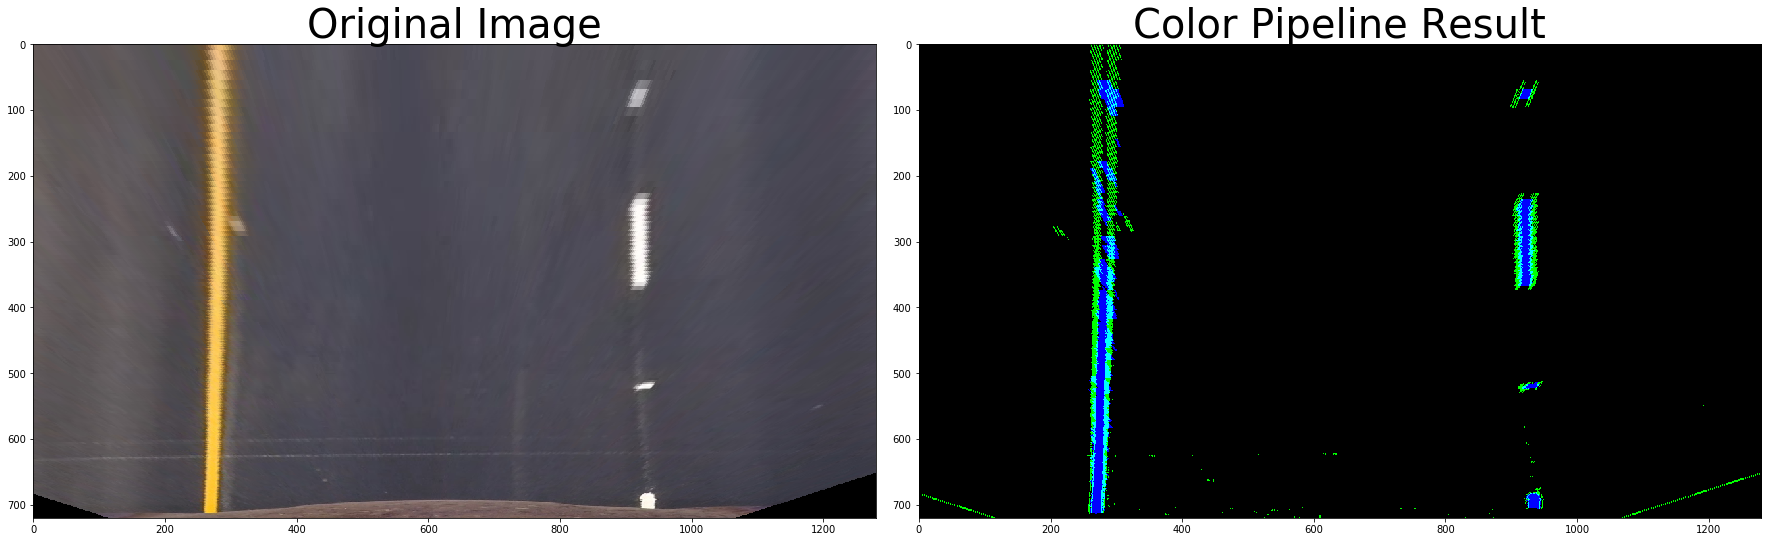

In [15]:
binary_warped,color_binary = color_gradient_pipeline(img_warped)

#save the output
cv2.imwrite('output_images/straight_lines1_binary.jpg',255*binary_warped)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img_warped)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(color_binary)
ax2.set_title('Color Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Line class to track lane lines

In [16]:
# Define a class to receive the characteristics of each line detection
from collections import deque

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last fit
        self.fitx = None
        # y values of the last fit
        self.fity = None
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        self.smooth_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # history of fits
        self.old_fits = deque(3*[None], 3)

## Determine the curvature of the lane

In [17]:
# Define conversions in x and y from pixels space to meters
# ym_per_pix meters per pixel in y dimension
# xm_per_pix meters per pixel in x dimension

def finding_curvature(fitx, fity, xm_per_pix = 3.7/700 ,ym_per_pix = 30.0/720):

    y_eval = np.max(fity)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(fity*ym_per_pix, fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    # Now our radius of curvature is in meters
    return curverad

## Detect lane pixels and fit to find the lane boundary.

In [18]:
# nwindows: choose the number of sliding windows
# margin sets the width of the windows +/- margin
# minpix set minimum number of pixels found to recenter window
# ym_per_pix meters per pixel in y dimension
# xm_per_pix meters per pixel in x dimension

def finding_new_lines(binary_warped, left_line, right_line, nwindows = 9, margin=80, minpix = 50):
        
    height = binary_warped.shape[0]
    
    histogram = np.sum(binary_warped[height//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
    # Set height of windows
    window_height = height//nwindows
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin

        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values
    fity = np.linspace(0, height-1, height )
    left_fitx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    right_fitx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
    
    # Fill line attributes
    left_line.detected = True
    left_line.current_fit = left_fit
 
    left_line.fitx = left_fitx
    left_line.fity = fity
    
    left_line.allx =leftx
    left_line.ally = lefty
    
    left_line.line_base_pos = leftx_base
    
    
    right_line.detected = True
    right_line.current_fit = right_fit

    right_line.fitx = right_fitx
    right_line.fity = fity
    
    right_line.allx = rightx
    right_line.ally = righty
    
    right_line.line_base_pos = rightx_base

    return left_line,right_line

### Look-Ahead Filter (eliminate sliding window step if lines already exist)

In [19]:
def finding_existing_lines(binary_warped, left_line, right_line, margin=80):
    
    height = binary_warped.shape[0]

    histogram = np.sum(binary_warped[height//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    if left_line.old_fits[0] == None:
        left_line.old_fits.append(left_line.current_fit)
    else:
        left_line.old_fits.popleft()
        left_line.old_fits.append(left_line.current_fit)
        
    if right_line.old_fits[0] == None:
        right_line.old_fits.popleft()
        right_line.old_fits.append(right_line.current_fit)
        
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    if left_line.best_fit == None:
        left_existing_fit = left_line.current_fit
    else:
        left_existing_fit = left_line.best_fit
    
    if right_line.best_fit == None: 
        right_existing_fit = right_line.current_fit
    else:
        right_existing_fit = right_line.best_fit
        
    left_lane_inds = ((nonzerox > (left_existing_fit[0]*(nonzeroy**2) +\
                                   left_existing_fit[1]*nonzeroy +\
                                   left_existing_fit[2] - margin)) &\
                      (nonzerox < (left_existing_fit[0]*(nonzeroy**2) +\
                                   left_existing_fit[1]*nonzeroy +\
                                   left_existing_fit[2] + margin))).nonzero()[0]
    
    right_lane_inds = ((nonzerox > (right_existing_fit[0]*(nonzeroy**2) +\
                                    right_existing_fit[1]*nonzeroy +\
                                    right_existing_fit[2] - margin)) &\
                       (nonzerox < (right_existing_fit[0]*(nonzeroy**2) +\
                                    right_existing_fit[1]*nonzeroy +\
                                    right_existing_fit[2] + margin))).nonzero()[0]  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values
    fity = np.linspace(0, height-1, height )
    left_fitx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    right_fitx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
    
    
    # Fill line attributes
    left_line.diffs = left_line.current_fit - left_fit
    left_line.current_fit = left_fit
    
    left_line.fitx = left_fitx
    left_line.fity = fity
    
    left_line.allx =leftx
    left_line.ally = lefty
    
    left_line.line_base_pos = leftx_base

    
    right_line.diffs = right_line.current_fit - right_fit
    right_line.current_fit = right_fit

    right_line.fitx = right_fitx
    right_line.fity = fity
    
    right_line.allx = rightx
    right_line.ally = righty
    
    right_line.line_base_pos = rightx_base
    
    
    return left_line,right_line

### Testing the line finding codes

True

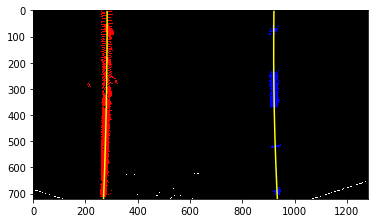

In [20]:
left_line,right_line = finding_new_lines(binary_warped,Line(),Line())

# Create an output image to draw on and visualize the result
out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)

out_img[left_line.ally, left_line.allx] = [255, 0, 0]
out_img[right_line.ally, right_line.allx] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(left_line.fitx, left_line.fity, color='yellow')
plt.plot(right_line.fitx, right_line.fity, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

cv2.imwrite('output_images/find_new_lines_straight_lines1.jpg',out_img)


True

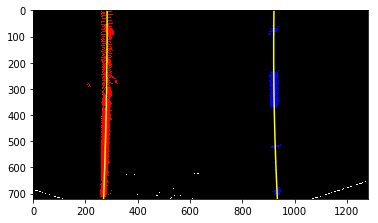

In [21]:
left_line, right_line = finding_existing_lines(binary_warped, left_line, right_line)

# Create an output image to draw on and visualize the result
out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)

# Color in left and right line pixels
out_img[left_line.ally, left_line.allx] = [255, 0, 0]
out_img[right_line.ally, right_line.allx] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(left_line.fitx, left_line.fity, color='yellow')
plt.plot(right_line.fitx, right_line.fity, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

cv2.imwrite('output_images/find_existing_lines_straight_lines1.jpg',out_img)


## Similarity and Distance

In [22]:
# calculate the similarity score of lines and their distance
def match_shapes(left_fit,right_fit,img_size):
    
    height = img_size[1]
    fity = np.linspace(0, height-1, height )
    left_fitx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    right_fitx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
    
    left_warp_zero = np.zeros(img_size[::-1]).astype(np.uint8)
    right_warp_zero = np.zeros(img_size[::-1]).astype(np.uint8)

    pts_left = np.array([np.transpose(np.vstack([left_fitx, fity]))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, fity]))])

    cv2.polylines(left_warp_zero, np.int_(pts_left), False,(255,255, 255),5)
    cv2.polylines(right_warp_zero, np.int_(pts_right), False,(255,255, 255),5)

    _, lc, _ = cv2.findContours(left_warp_zero, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS) 
    _, rc, _ = cv2.findContours(right_warp_zero, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS) 

    hd = cv2.createHausdorffDistanceExtractor()
    distance = hd.computeDistance(lc[0],rc[0])
    
    return cv2.matchShapes(left_warp_zero,right_warp_zero,1,0.0),distance

## Sanity Check the validity of lane lines

In [56]:
# sanity check function
def sanity_check(left_line,right_line, img_size, min_curv_US = 168.0, max_curv_US = 1436.0, smooth_factor=0.3):
    # xm_per_pix = 3.7/700, ym_per_pix = 30/720

    match_score, distance = match_shapes(left_line.current_fit,right_line.current_fit,img_size)
    
    height = img_size[1]
    width = img_size[0]
    
    left_new_fit = left_line.current_fit
    right_new_fit = right_line.current_fit
    
    
    #curvature check (Two first atrributes of fit)
    left_line.radius_of_curvature = finding_curvature(left_line.fitx,left_line.fity) 
    right_line.radius_of_curvature = finding_curvature(right_line.fitx,right_line.fity)
    if (left_line.radius_of_curvature < min_curv_US) & (right_line.radius_of_curvature < min_curv_US):
        if (left_line.best_fit == None) | (right_line.best_fit == None):
            left_line.detected = False
            right_line.detected = False
            return left_line,right_line # using old best fit and find lines again
        else:
            left_new_fit = left_line.best_fit
            right_new_fit = right_line.best_fit


    elif (left_line.radius_of_curvature < min_curv_US):
        left_line.radius_of_curvature = right_line.radius_of_curvature
        left_new_fit[0:2] = right_line.current_fit[0:2]
        left_new_fit[2] = right_line.current_fit[2] - 670

                

    elif (right_line.radius_of_curvature < min_curv_US):
        right_line.radius_of_curvature = left_line.radius_of_curvature
        right_new_fit[0:2] = left_line.current_fit[0:2]
        right_new_fit[2] = left_line.current_fit[2] + 670

    
    # parallel check and distance check
    if  (match_score > 0.1) | (distance < 600) | (distance > 800):
        if (left_line.best_fit == None) | (right_line.best_fit == None):
            if( len(left_line.ally) > len(right_line.ally) ):
                right_line.radius_of_curvature = left_line.radius_of_curvature
                right_new_fit[0:2] = left_line.current_fit[0:2]
                right_new_fit[2] = left_line.current_fit[2] + 670

            else:
                left_line.radius_of_curvature = right_line.radius_of_curvature
                left_new_fit[0:2] = right_line.current_fit[0:2]
                left_new_fit[2] = right_line.current_fit[2] - 670
        else:
            rhist_match, rhist_dist = match_shapes(right_new_fit,right_line.old_fits[len(right_line.old_fits)-1],img_size)
            lhist_match, lhist_dist  = match_shapes(left_new_fit,left_line.old_fits[len(left_line.old_fits)-1],img_size)
            
            if (abs(rhist_dist) > 100): # avoid jumping lanes
                right_new_fit = right_line.best_fit
            
            elif (abs(lhist_dist) > 100):
                left_new_fit = left_line.best_fit

    # lane location check (last attribute of fit)
    if (left_line.line_base_pos > width/2) & (right_line.line_base_pos < width/2): #swap lines!!!
        tmp = left_line
        left_line = right_line
        right_line = tmp
        
    elif (left_line.line_base_pos > width/2):     # left line should be on the left
        left_line.line_base_pos = right_line.line_base_pos - 670 # 3.7 meters in pixel scale
        left_new_fit[2] = right_line.current_fit[2] - 670
        
    elif (right_line.line_base_pos < width/2):     # right line should be on the right
        right_line.line_base_pos = left_line.line_base_pos + 670 # 3.7 meters in pixel scale
        right_new_fit[2] = left_line.current_fit[2] + 670
    
    
    fity = np.linspace(0, height-1, height )
    left_fitx = left_new_fit[0]*fity**2 + left_new_fit[1]*fity + left_new_fit[2]
    right_fitx = right_new_fit[0]*fity**2 + right_new_fit[1]*fity + right_new_fit[2]
    
    left_line.current_fit = left_new_fit
    left_line.fitx = left_fitx
    left_line.fity = fity   
    left_line.radius_of_curvature = finding_curvature(left_line.fitx,left_line.fity) 
    
    if left_line.best_fit == None:
        left_line.bestx = left_fitx
        left_line.best_fit = left_new_fit
        left_line.smooth_curvature = finding_curvature(left_line.bestx,left_line.fity)
    else:
        left_line.best_fit = (1-smooth_factor)*left_line.best_fit + smooth_factor*left_new_fit
        left_bestx = left_line.best_fit[0]*fity**2 + left_line.best_fit[1]*fity + left_line.best_fit[2]
        left_line.bestx = left_bestx
        left_line.smooth_curvature = (1-smooth_factor)*left_line.smooth_curvature + smooth_factor*finding_curvature(left_line.bestx,left_line.fity)
        
    
    right_line.current_fit = right_new_fit
    right_line.fitx = right_fitx
    right_line.fity = fity
    right_line.radius_of_curvature = finding_curvature(right_line.fitx,right_line.fity) 
    
    if right_line.best_fit == None: 
        right_line.bestx = right_fitx
        right_line.best_fit = right_new_fit
        right_line.smooth_curvature = finding_curvature(right_line.bestx,right_line.fity)

    else:
        right_line.best_fit = (1-smooth_factor)*right_line.best_fit + smooth_factor*right_new_fit
        right_bestx = right_line.best_fit[0]*fity**2 + right_line.best_fit[1]*fity + right_line.best_fit[2]
        right_line.bestx = right_bestx
        right_line.smooth_curvature = (1-smooth_factor)*right_line.smooth_curvature + smooth_factor*finding_curvature(right_line.bestx,right_line.fity)
            
    return left_line,right_line

## Warp the detected lane boundaries back onto the original image and output visual display of the lane boundaries.

In [24]:
def draw_lines(image,left_line,right_line, Minv, xm_per_pix = 3.7/700, ym_per_pix = 30/720):
    
    height = image.shape[0]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    if left_line.best_fit == None:
        left_existing_x = left_line.fitx
    else:
        left_existing_x = left_line.bestx
    
    if right_line.best_fit == None: 
        right_existing_x = right_line.fitx
    else:
        right_existing_x = right_line.bestx
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_existing_x, left_line.fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_existing_x, right_line.fity])))])
    
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Color in left and right line pixels
    color_warp[left_line.ally, left_line.allx] = [255, 0, 0]
    color_warp[right_line.ally, right_line.allx] = [0, 0, 255]
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warper(color_warp,Minv)
    # Combine the result with the original image
    overlayed = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # Calculate vehicle position with respect to center.
    lane_center = (right_line.line_base_pos + left_line.line_base_pos)/2
    vehicle_midpoint = np.int(image.shape[1]//2)
    
    vehicle_drift = (vehicle_midpoint - lane_center) * xm_per_pix
    
    if(vehicle_drift > 0):
        side = 'right'
    else:
        side = 'left'
    
    radius_of_curvature = min(left_line.smooth_curvature,right_line.smooth_curvature)
    
    if radius_of_curvature >= 10000: # probably straight road!
        radius_of_curvature = 9999.99
    # Output numerical estimation of lane curvature and vehicle position.
    text1 = 'Radius of Curvature = {:.2f}(m)'.format(radius_of_curvature)
    text2 = 'Vehicle is {:.2f}m {} of center'.format(abs(vehicle_drift),side)
                                                                          
    font = cv2.FONT_HERSHEY_SIMPLEX
    result = cv2.putText(overlayed, text1, (20,60), font, 2,(255,255,255),2)
    result = cv2.putText(overlayed, text2, (20,110), font, 2,(255,255,255),2)

    
    return result

### Check the visual boundaries

True

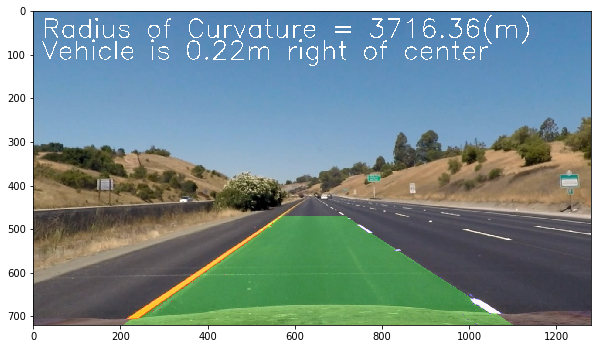

In [25]:
plt.figure(figsize=(10,10))
left_line,right_line = sanity_check(left_line,right_line,img_size)
result = draw_lines(undist_img,left_line, right_line, Minv)
plt.imshow(result)
result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/draw_back_straight_lines1.jpg',result)


## The completed pipeline

In [26]:
def advanced_lines_pipeline(img, mtx, dist, M, Minv):
    img_size = (img.shape[1], img.shape[0])
    
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    img_warped = warper(undist_img, M)
    binary_warped,a = color_gradient_pipeline(img_warped)

    
    if (advanced_lines_pipeline.left_line.detected == False)|(advanced_lines_pipeline.right_line.detected == False):
        advanced_lines_pipeline.left_line, advanced_lines_pipeline.right_line = \
        finding_new_lines(binary_warped, Line(), Line())
    else:
        advanced_lines_pipeline.left_line, advanced_lines_pipeline.right_line = \
        finding_existing_lines(binary_warped, advanced_lines_pipeline.left_line, advanced_lines_pipeline.right_line)
    
    advanced_lines_pipeline.left_line, advanced_lines_pipeline.right_line = sanity_check(advanced_lines_pipeline.left_line, advanced_lines_pipeline.right_line ,img_size)
    result = draw_lines(undist_img,advanced_lines_pipeline.left_line, advanced_lines_pipeline.right_line, Minv)
    return result

### Check the pipeline on test images

In [27]:
def process_image(image):
    return advanced_lines_pipeline(image, mtx = mtx, dist = dist, M = M, Minv = Minv)

In [42]:
test_images = glob.glob('test_images/*.jpg')

    # Step through the test images
for filename in test_images:
    test_img = mpimg.imread(filename)
    # make sure it is always a new detection!
    advanced_lines_pipeline.left_line = Line()
    advanced_lines_pipeline.right_line = Line()
    print(filename.split('/')[-1])
    output_img = process_image(test_img)
    output_img = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('output_images/'+filename.split('/')[-1],output_img)

test2.jpg
test6.jpg
straight_lines2.jpg
test1.jpg
straight_lines1.jpg
test3.jpg
test4.jpg
test5.jpg


### Check the pipline on video frames

In [59]:
# clip1 = VideoFileClip("project_video.mp4").subclip(36,45) #used these frames
# clip1.write_images_sequence("test_images/video/frame%04d.jpeg")

# Start with a new detection!
advanced_lines_pipeline.left_line = Line()
advanced_lines_pipeline.right_line = Line()

for i in range(50):
    video_img = mpimg.imread('test_images/video/frame0{}.jpeg'.format(str(i).zfill(3)))
    output_img = process_image(video_img)
    output_img = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('output_images/video/frame0{}.jpeg'.format(str(i).zfill(3)),output_img)

### Generating the video output

In [57]:
advanced_lines_pipeline.left_line = Line()
advanced_lines_pipeline.right_line = Line()
project_output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [03:41<00:00,  5.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 14min 6s, sys: 7.44 s, total: 14min 14s
Wall time: 3min 41s


In [5]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))